In [133]:
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from  datetime import datetime, timedelta
import gc
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import mean_squared_error
from math import sqrt
import sklearn

In [134]:
cal_dtype = {"event_name_1": "category", "event_name_2": "category", "event_type_1": "category", 
              "event_type_2": "category", "weekday": "category", 'wm_yr_wk': 'int16', "wday": "int16",
              "month": "int16", "year": "int16", "snap_CA": "int8", 'snap_TX': 'int8', 'snap_WI': 'int8'}
price_dtype = {"store_id": "category", "item_id": "category", "wm_yr_wk": "int16","sell_price":"float32"}

In [135]:
dt = pd.read_csv('sales_train_validation.csv')
dt = dt.astype({col: 'int32' for col in dt.select_dtypes('int64').columns})

In [136]:
cal = pd.read_csv('calendar.csv', dtype = cal_dtype)
cal['date'] = pd.to_datetime(cal['date'])
for col, col_dtype in cal_dtype.items():
    if col_dtype == "category":
        cal[col] = cal[col].cat.codes.astype("int16")
        cal[col] -= cal[col].min()
cal = cal.astype({col: 'int32' for col in cal.select_dtypes('int64').columns})
cal_1 = cal[0:1913]
future = cal[0:1941]

In [72]:
#prices = pd.read_csv('sell_prices.csv')

In [137]:
val_values = pd.read_csv('validation_values.csv')

In [138]:
dt_st_dep = dt.groupby(['store_id', 'dept_id'], as_index=False).sum()

In [139]:
temp = val_values
temp[['a', 'b', 'c', 'd', 'e', 'f']] = temp.id.str.split('_', expand=True)
temp['store_id'] = temp['d']+ '_' + temp['e']
temp['dep_id'] = temp['a']+ '_' + temp['b']
#temp = temp.drop(['a', 'b', 'c', 'd', 'e', 'f'], axis=1)
#temp = temp.drop(["('a', 'b', 'c', 'd', 'e', 'f')"], axis=1)
val_group = temp.groupby(['store_id', 'dep_id'], as_index=False).sum()

In [140]:
dt_y_pred = dt[['id','dept_id','store_id', 'd_1886', 'd_1887', 'd_1888', 'd_1889', 'd_1890', 'd_1891',
               'd_1892', 'd_1893', 'd_1894', 'd_1895', 'd_1896', 'd_1897', 'd_1898',
               'd_1899', 'd_1900', 'd_1901', 'd_1902', 'd_1903', 'd_1904', 'd_1905', 'd_1906',
               'd_1907', 'd_1908', 'd_1909', 'd_1910', 'd_1911', 'd_1912', 'd_1913',]]
d_id = dt_y_pred.dept_id.unique()
d_id_lst = d_id.tolist()
st_id = dt_y_pred.store_id.unique()
st_id_lst = st_id.tolist()
print(st_id_lst, d_id_lst)

['CA_1', 'CA_2', 'CA_3', 'CA_4', 'TX_1', 'TX_2', 'TX_3', 'WI_1', 'WI_2', 'WI_3'] ['HOBBIES_1', 'HOBBIES_2', 'HOUSEHOLD_1', 'HOUSEHOLD_2', 'FOODS_1', 'FOODS_2', 'FOODS_3']


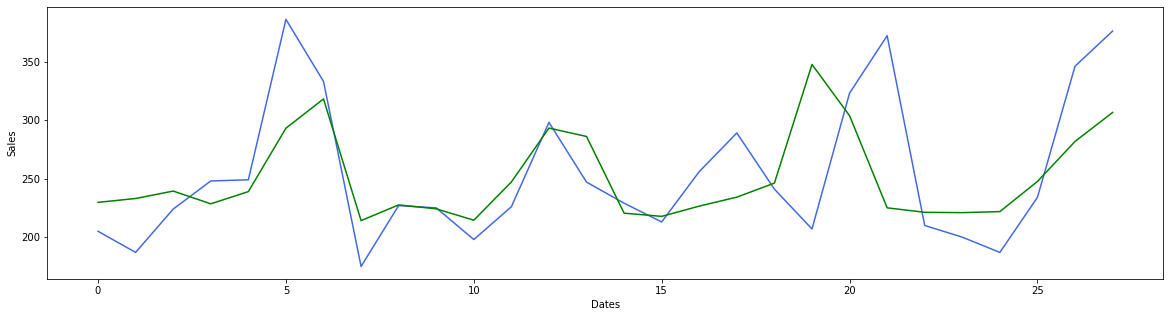

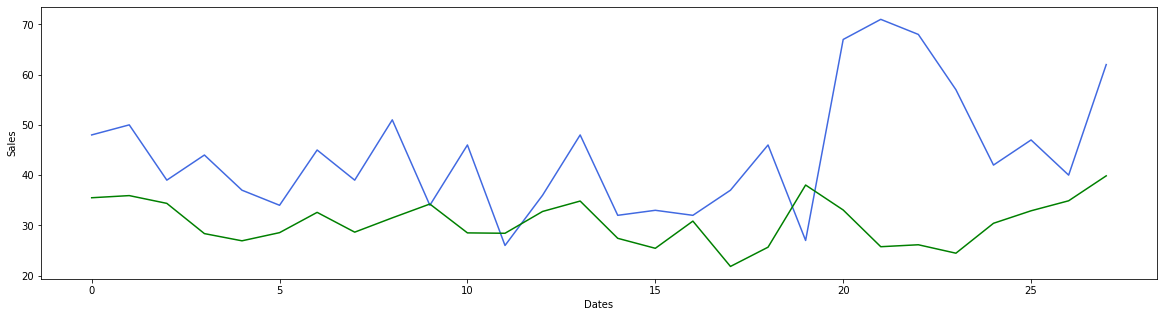

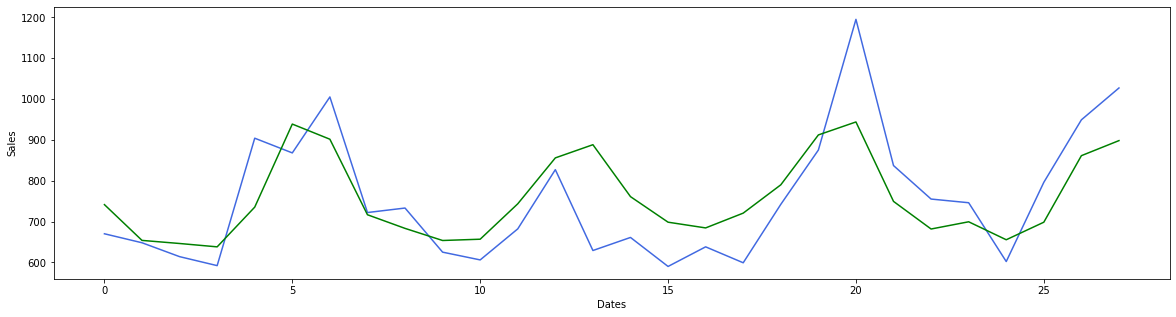

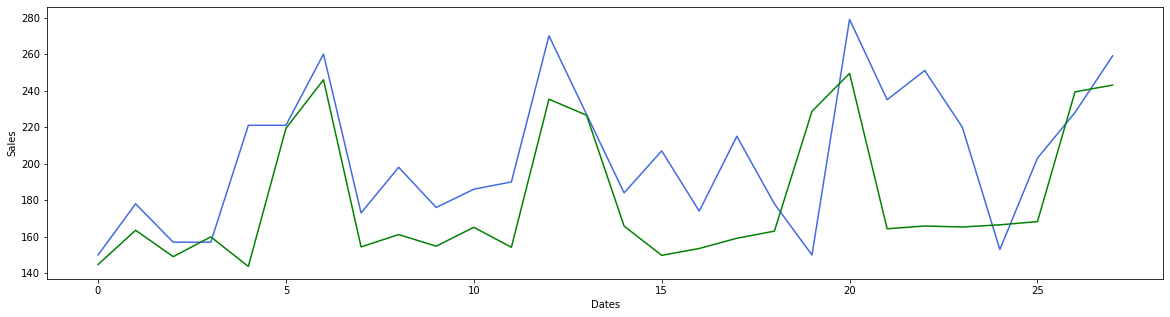

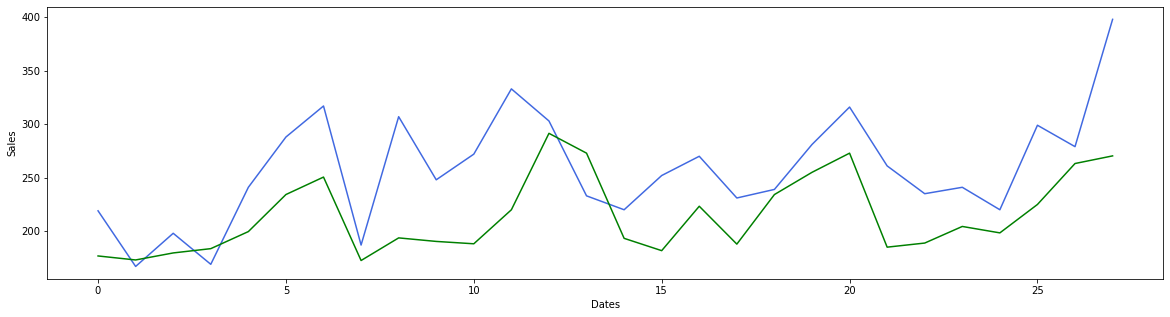

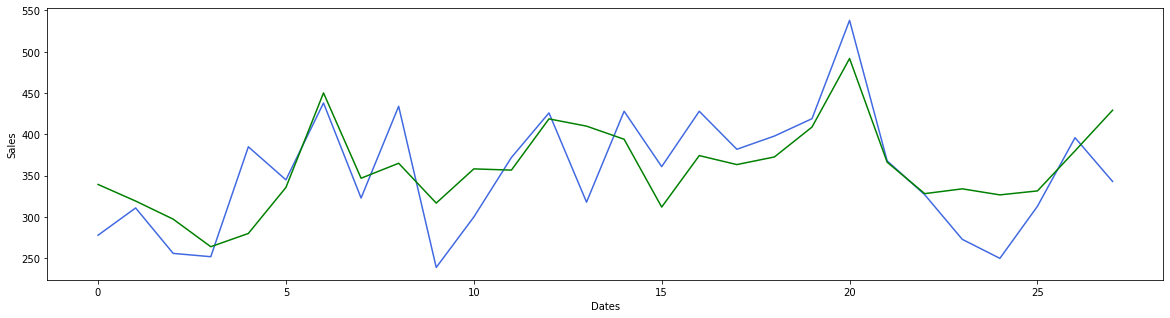

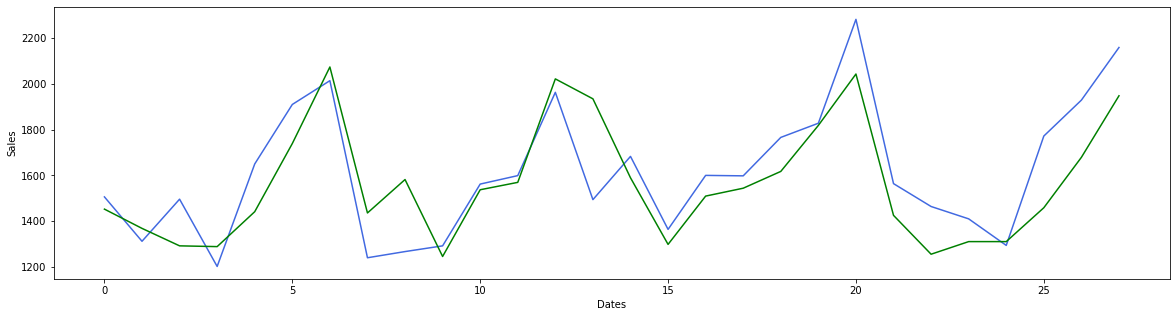

<Figure size 1440x360 with 0 Axes>

In [145]:
s_id = 'TX_1'
for d_id in d_id_lst:
    #Get train set values for specific d_id and s_id
    dt_st_dep_n = dt_st_dep.loc[(dt_st_dep['dept_id'] == d_id) & (dt_st_dep['store_id'] == s_id)]

    #Get validation values for specific d_id and s_id
    val_n = val_group.loc[(val_group['dep_id'] == d_id) & (val_group['store_id'] == s_id)]
    val_n = val_n.reset_index(drop=True)
    y_lst = val_n.loc[0, :].values.tolist()
    y_lst.pop(0)
    y_lst.pop(0)

    #Transform train data
    catcols = ['store_id', 'dept_id']
    dt_st_dep_n = pd.melt(dt_st_dep_n, 
                        id_vars = catcols, 
                        value_vars = [col for col in dt_st_dep_n.columns if col.startswith('d_')], 
                        var_name = 'd', 
                        value_name = 'sales')
    dt_st_dep_n = dt_st_dep_n.merge(cal, on= "d", copy = False)
    df_train = dt_st_dep_n

    lags = [7, 28]
    lag_cols = [f"lag_{lag}" for lag in lags ]
    for lag, lag_col in zip(lags, lag_cols):
        df_train[lag_col] = df_train['sales'].shift(lag)
    wins = [7, 28]
    for win in wins :
        for lag,lag_col in zip(lags, lag_cols):
            df_train[f"rmean_{lag}_{win}"] = df_train[lag_col].transform(lambda x : x.rolling(win).mean()) 
    df_train = df_train.drop(['store_id', 'dept_id', 'd', 'date', 'wm_yr_wk', 'weekday'], axis=1)
    df_train.dropna(inplace = True)

    y = df_train['sales']
    if (s_id.split('_')[0] == 'CA'):
        X_train = df_train.drop(['sales', 'snap_TX', 'snap_WI'], axis=1)
    elif (s_id.split('_')[0] == 'TX'):
        X_train = df_train.drop(['sales', 'snap_CA', 'snap_WI'], axis=1)
    else:
        X_train = df_train.drop(['sales', 'snap_TX', 'snap_CA'], axis=1)


    #Define and fit regressor
    gbr = GradientBoostingRegressor(max_depth=5)
    #grid_values_gbr = {'n_estimators': [10, 50, 100, 500, 1000], 'max_depth':[3, 5, 7, 9], 'learning_rate':[0.01, 0.05, 0.1, 0.2]}
    #grid_clf_gbr = GridSearchCV(gbr, param_grid = grid_values_gbr, scoring = 'neg_root_mean_squared_error', cv =5)
    #grid_clf_gbr.fit(X_train, y)
    #gbr = grid_clf_gbr.best_estimator_
    gbr.fit(X_train,y)

    # Preparing dataset for prediction
    dt_pred = dt_st_dep.loc[(dt_st_dep['dept_id'] == d_id) & (dt_st_dep['store_id'] == s_id)]
    dt_pred = pd.melt(dt_pred, 
                        id_vars = catcols, 
                        value_vars = [col for col in dt_pred.columns if col.startswith('d_')], 
                        var_name = 'd', 
                        value_name = 'sales')
    for i in range(28):
        j=i+1914
        d = 'd_'+str(j)
        app_list = [s_id, d_id, d, -1]
        dt_pred.loc[len(dt_pred)] = app_list
    dt_pred = dt_pred.merge(future, on= "d", copy = False)
    dt_pred = dt_pred.drop(['store_id', 'dept_id', 'd', 'date', 'wm_yr_wk', 'weekday'], axis=1)

    #Getting features and predicting values for 1st week
    lags = [7, 28]
    lag_cols = [f"lag_{lag}" for lag in lags ]
    for lag, lag_col in zip(lags, lag_cols):
        dt_pred[lag_col] = dt_pred['sales'].shift(lag)
    wins = [7, 28]
    for win in wins :
        for lag,lag_col in zip(lags, lag_cols):
            dt_pred[f"rmean_{lag}_{win}"] = dt_pred[lag_col].transform(lambda x : x.rolling(win).mean()) 
    if (s_id.split('_')[0] == 'CA'):
        X_test_tmp = dt_pred.drop(['sales', 'snap_TX', 'snap_WI'], axis=1)
    elif (s_id.split('_')[0] == 'TX'):
        X_test_tmp = dt_pred.drop(['sales', 'snap_CA', 'snap_WI'], axis=1)
    else:
        X_test_tmp = dt_pred.drop(['sales', 'snap_TX', 'snap_CA'], axis=1)
    X_test_curr = X_test_tmp[1913:1920]
    y_pred_curr = gbr.predict(X_test_curr)
    y_pred_curr_lst = list(y_pred_curr)

    #Setting values for 1st week
    dt_pred.loc[1913, 'sales']=y_pred_curr_lst[0]
    dt_pred.loc[1914, 'sales']=y_pred_curr_lst[1]
    dt_pred.loc[1915, 'sales']=y_pred_curr_lst[2]
    dt_pred.loc[1916, 'sales']=y_pred_curr_lst[3]
    dt_pred.loc[1917, 'sales']=y_pred_curr_lst[4]
    dt_pred.loc[1918, 'sales']=y_pred_curr_lst[5]
    dt_pred.loc[1919, 'sales']=y_pred_curr_lst[6]

    #Getting features and predicting values for 2nd week
    lags = [7, 28]
    lag_cols = [f"lag_{lag}" for lag in lags ]
    for lag, lag_col in zip(lags, lag_cols):
        dt_pred[lag_col] = dt_pred['sales'].shift(lag)
    wins = [7, 28]
    for win in wins :
        for lag,lag_col in zip(lags, lag_cols):
            dt_pred[f"rmean_{lag}_{win}"] = dt_pred[lag_col].transform(lambda x : x.rolling(win).mean()) 
    if (s_id.split('_')[0] == 'CA'):
        X_test_tmp = dt_pred.drop(['sales', 'snap_TX', 'snap_WI'], axis=1)
    elif (s_id.split('_')[0] == 'TX'):
        X_test_tmp = dt_pred.drop(['sales', 'snap_CA', 'snap_WI'], axis=1)
    else:
        X_test_tmp = dt_pred.drop(['sales', 'snap_TX', 'snap_CA'], axis=1)
    X_test_curr = X_test_tmp[1920:1927]
    y_pred_curr = gbr.predict(X_test_curr)
    y_pred_curr_lst = list(y_pred_curr)

    #Setting values for 2nd week
    dt_pred.loc[1920, 'sales']=y_pred_curr_lst[0]
    dt_pred.loc[1921, 'sales']=y_pred_curr_lst[1]
    dt_pred.loc[1922, 'sales']=y_pred_curr_lst[2]
    dt_pred.loc[1923, 'sales']=y_pred_curr_lst[3]
    dt_pred.loc[1924, 'sales']=y_pred_curr_lst[4]
    dt_pred.loc[1925, 'sales']=y_pred_curr_lst[5]
    dt_pred.loc[1926, 'sales']=y_pred_curr_lst[6]

    # Getting features and predicting values for 3rd week
    lags = [7, 28]
    lag_cols = [f"lag_{lag}" for lag in lags ]
    for lag, lag_col in zip(lags, lag_cols):
        dt_pred[lag_col] = dt_pred['sales'].shift(lag)
    wins = [7, 28]
    for win in wins :
        for lag,lag_col in zip(lags, lag_cols):
            dt_pred[f"rmean_{lag}_{win}"] = dt_pred[lag_col].transform(lambda x : x.rolling(win).mean()) 
    if (s_id.split('_')[0] == 'CA'):
        X_test_tmp = dt_pred.drop(['sales', 'snap_TX', 'snap_WI'], axis=1)
    elif (s_id.split('_')[0] == 'TX'):
        X_test_tmp = dt_pred.drop(['sales', 'snap_CA', 'snap_WI'], axis=1)
    else:
        X_test_tmp = dt_pred.drop(['sales', 'snap_TX', 'snap_CA'], axis=1)
    X_test_curr = X_test_tmp[1927:1934]
    y_pred_curr = gbr.predict(X_test_curr)
    y_pred_curr_lst = list(y_pred_curr)

    # Setting values for 3rd week
    dt_pred.loc[1927, 'sales']=y_pred_curr_lst[0]
    dt_pred.loc[1928, 'sales']=y_pred_curr_lst[1]
    dt_pred.loc[1929, 'sales']=y_pred_curr_lst[2]
    dt_pred.loc[1930, 'sales']=y_pred_curr_lst[3]
    dt_pred.loc[1931, 'sales']=y_pred_curr_lst[4]
    dt_pred.loc[1932, 'sales']=y_pred_curr_lst[5]
    dt_pred.loc[1933, 'sales']=y_pred_curr_lst[6]

    # Getting features and predicting values for 4th week
    lags = [7, 28]
    lag_cols = [f"lag_{lag}" for lag in lags ]
    for lag, lag_col in zip(lags, lag_cols):
        dt_pred[lag_col] = dt_pred['sales'].shift(lag)
    wins = [7, 28]
    for win in wins :
        for lag,lag_col in zip(lags, lag_cols):
            dt_pred[f"rmean_{lag}_{win}"] = dt_pred[lag_col].transform(lambda x : x.rolling(win).mean()) 
    if (s_id.split('_')[0] == 'CA'):
        X_test_tmp = dt_pred.drop(['sales', 'snap_TX', 'snap_WI'], axis=1)
    elif (s_id.split('_')[0] == 'TX'):
        X_test_tmp = dt_pred.drop(['sales', 'snap_CA', 'snap_WI'], axis=1)
    else:
        X_test_tmp = dt_pred.drop(['sales', 'snap_TX', 'snap_CA'], axis=1)
    X_test_curr = X_test_tmp[1934:1941]
    y_pred_curr = gbr.predict(X_test_curr)
    y_pred_curr_lst = list(y_pred_curr)

    #Setting the predicted values for 4th week
    dt_pred.loc[1934, 'sales']=y_pred_curr_lst[0]
    dt_pred.loc[1935, 'sales']=y_pred_curr_lst[1]
    dt_pred.loc[1936, 'sales']=y_pred_curr_lst[2]
    dt_pred.loc[1937, 'sales']=y_pred_curr_lst[3]
    dt_pred.loc[1938, 'sales']=y_pred_curr_lst[4]
    dt_pred.loc[1939, 'sales']=y_pred_curr_lst[5]
    dt_pred.loc[1940, 'sales']=y_pred_curr_lst[6]

    #Plotting predicted and actual values
    dt_pred_temp = dt_pred.tail(28)
    y_pred_lst = dt_pred_temp['sales'].values.tolist()
    plt.rcParams["figure.figsize"] = (20,5)
    plt.plot(y_lst, c='royalblue')
    plt.plot(y_pred_lst, c='green')
    ax = plt.gca()
    ax.set_ylabel('Sales')
    ax.set_xlabel('Dates')
    plt.show()
    plt.clf()